In [83]:
#import libs
import os
import time
import numpy as np
from datetime import date
from dateutil.parser import parse
import pandas as pd
from datetime import datetime
from pandas import DataFrame
import statistics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
dir_path = os.getcwd() + '/Performance_Analytics/US_Performance/'
nameofcsvfile = 'movie_metadata.xls'
file_path = dir_path + nameofcsvfile
file_path

'/var/lib/jupyter/Performance_Analytics/US_Performance/movie_metadata.xls'

In [41]:
# get data
def getdata(path_to_composite_file):
    file_path = os.getcwd() + '/Performance_Analytics/US_Performance/'+ path_to_composite_file
    xls = pd.ExcelFile(file_path)
    df1 = pd.read_excel(xls, 'movie_metadata')
    return df1

In [42]:
data=getdata('movie_metadata.xls')
print(len(data), data.columns)
#data.head()

5043 Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_movie_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'movie_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')


In [43]:
print(len(data[data['gross'].isnull()]) )# 884 rows with target missing
data.dropna(subset=['gross'], inplace=True) #dropping above rows
print(len(data))

884
4159


In [44]:
# correlation with the 'gross' as a target since we are aiming profitable movies
data[data.columns[1:]].corr()['gross'][:].sort_values(ascending=False)

gross                        1.000000
num_voted_users              0.637271
num_user_for_reviews         0.559958
num_critic_for_reviews       0.480601
movie_facebook_likes         0.378082
actor_3_facebook_likes       0.308026
actor_2_facebook_likes       0.262768
duration                     0.250298
cast_total_facebook_likes    0.247400
movie_score                  0.198021
actor_1_facebook_likes       0.154468
director_facebook_likes      0.144945
budget                       0.102179
aspect_ratio                 0.069346
title_year                   0.030886
facenumber_in_poster        -0.027755
Name: gross, dtype: float64

In [45]:
# One strategy can be to drop the variables
#drop na/empty rows to start with
data=data.dropna(how='any')
len(data)

3756

In [46]:
#dropping the variables that are recorded after the movie is released - this is to avoid target leakage OR are not useful
cols_target_leak=['gross','num_critic_for_reviews','num_voted_users','movie_movie_link','num_user_for_reviews','num_critic_for_reviews','movie_score']
y = data.gross
X = data.drop(cols_target_leak, axis=1)
print(X.shape, y.shape)
X.dtypes

(3756, 22) (3756,)


color                         object
director_name                 object
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
genres                        object
actor_1_name                  object
movie_title                   object
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
aspect_ratio                 float64
movie_facebook_likes           int64
dtype: object

In [108]:
X.columns.tolist()

['color',
 'director_name',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_2_name',
 'actor_1_facebook_likes',
 'genres',
 'actor_1_name',
 'movie_title',
 'cast_total_facebook_likes',
 'actor_3_name',
 'facenumber_in_poster',
 'plot_keywords',
 'language',
 'country',
 'content_rating',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'aspect_ratio',
 'movie_facebook_likes']

In [47]:
#function to convert object type into category and LabelEncode them as a strategy to start with
def find_and_convert_objecttype(data):
    object_list=list(data.loc[:,data.dtypes == object].columns)
    for col in object_list:
        data[col] = data[col].astype('category')
    #print(cols_categorical)
    LE = LabelEncoder()
    for column in object_list:
        data[column] = LE.fit_transform(data[column])
    data.head()
    return data

In [48]:
X=find_and_convert_objecttype(X)
print(len(X), len(y))
X.isnull().any()

3756 3756


color                        False
director_name                False
duration                     False
director_facebook_likes      False
actor_3_facebook_likes       False
actor_2_name                 False
actor_1_facebook_likes       False
genres                       False
actor_1_name                 False
movie_title                  False
cast_total_facebook_likes    False
actor_3_name                 False
facenumber_in_poster         False
plot_keywords                False
language                     False
country                      False
content_rating               False
budget                       False
title_year                   False
actor_2_facebook_likes       False
aspect_ratio                 False
movie_facebook_likes         False
dtype: bool

In [49]:
# Splitting train and test for model building
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size = 0.2)
print(len(train_X), len(val_X), len(train_y), len(val_y) )

3004 752 3004 752


In [50]:
# Random forest
rf_model = RandomForestRegressor(n_estimators = 500, random_state = 0)
rf_model.fit(train_X,train_y)
print(mean_absolute_error(val_y,rf_model.predict(val_X)))

27528007.802087765


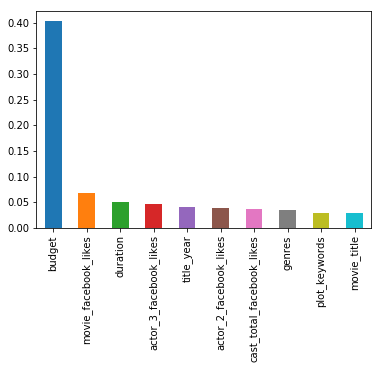

In [51]:
feat_importances = pd.Series(rf_model.feature_importances_, index=train_X.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [52]:
# XGB
ts = time.time()

model = XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    train_X, 
    train_y, 
    eval_metric="rmse", 
    eval_set=[(train_X,train_y), (val_X, val_y)], 
    verbose=False, 
    early_stopping_rounds = 10)
time.time() - ts

0.9625561237335205

In [117]:
#predictions = model.predict(val_X).clip(0, 20)
#len(model.predict(val_X)) == len((val_y))
data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_movie_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'movie_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

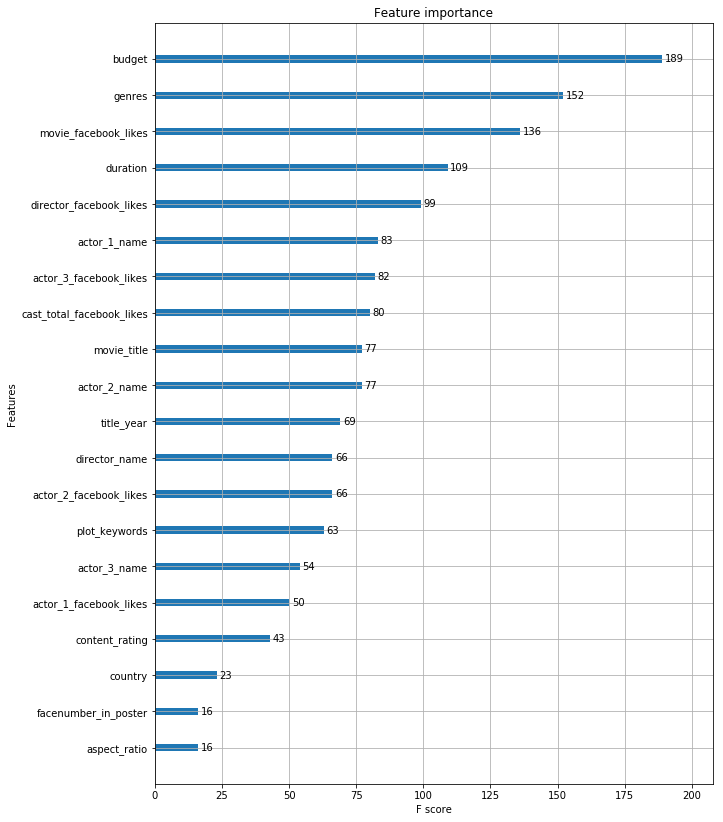

In [54]:
plot_features(model, (10,14))



Once we know the important features, we can see the distribution of them with the target to get more insights

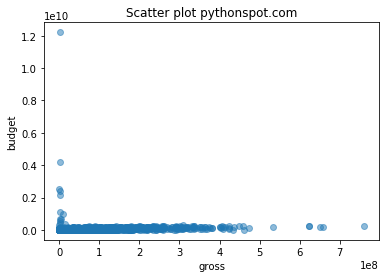

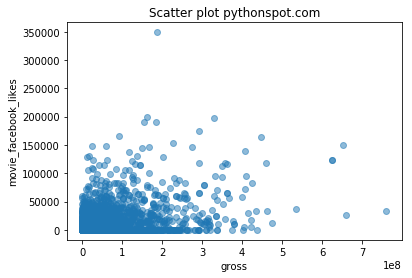

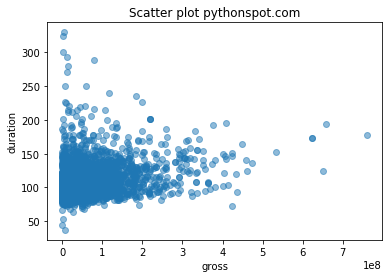

In [120]:
plt.scatter(data['gross'],data['budget'], alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('gross')
plt.ylabel('budget')
plt.show()

plt.scatter(data['gross'],data['movie_facebook_likes'], alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('gross')
plt.ylabel('movie_facebook_likes')
plt.show()

plt.scatter(data['gross'],data['duration'], alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('gross')
plt.ylabel('duration')
plt.show()

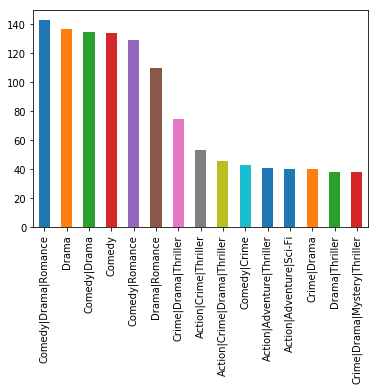

In [121]:
# Genres distribution
(data['genres'].groupby(data['gross']).sum().sort_values()).value_counts()[:15].plot(kind='bar')

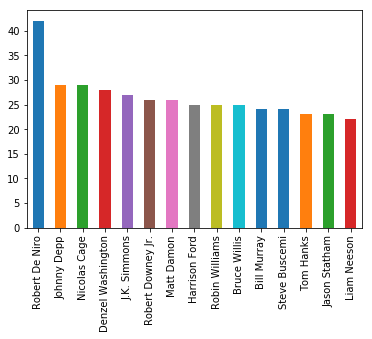

In [116]:
(data['actor_1_name'].groupby(data['gross']).sum().sort_values()).value_counts()[:15].plot(kind='bar')